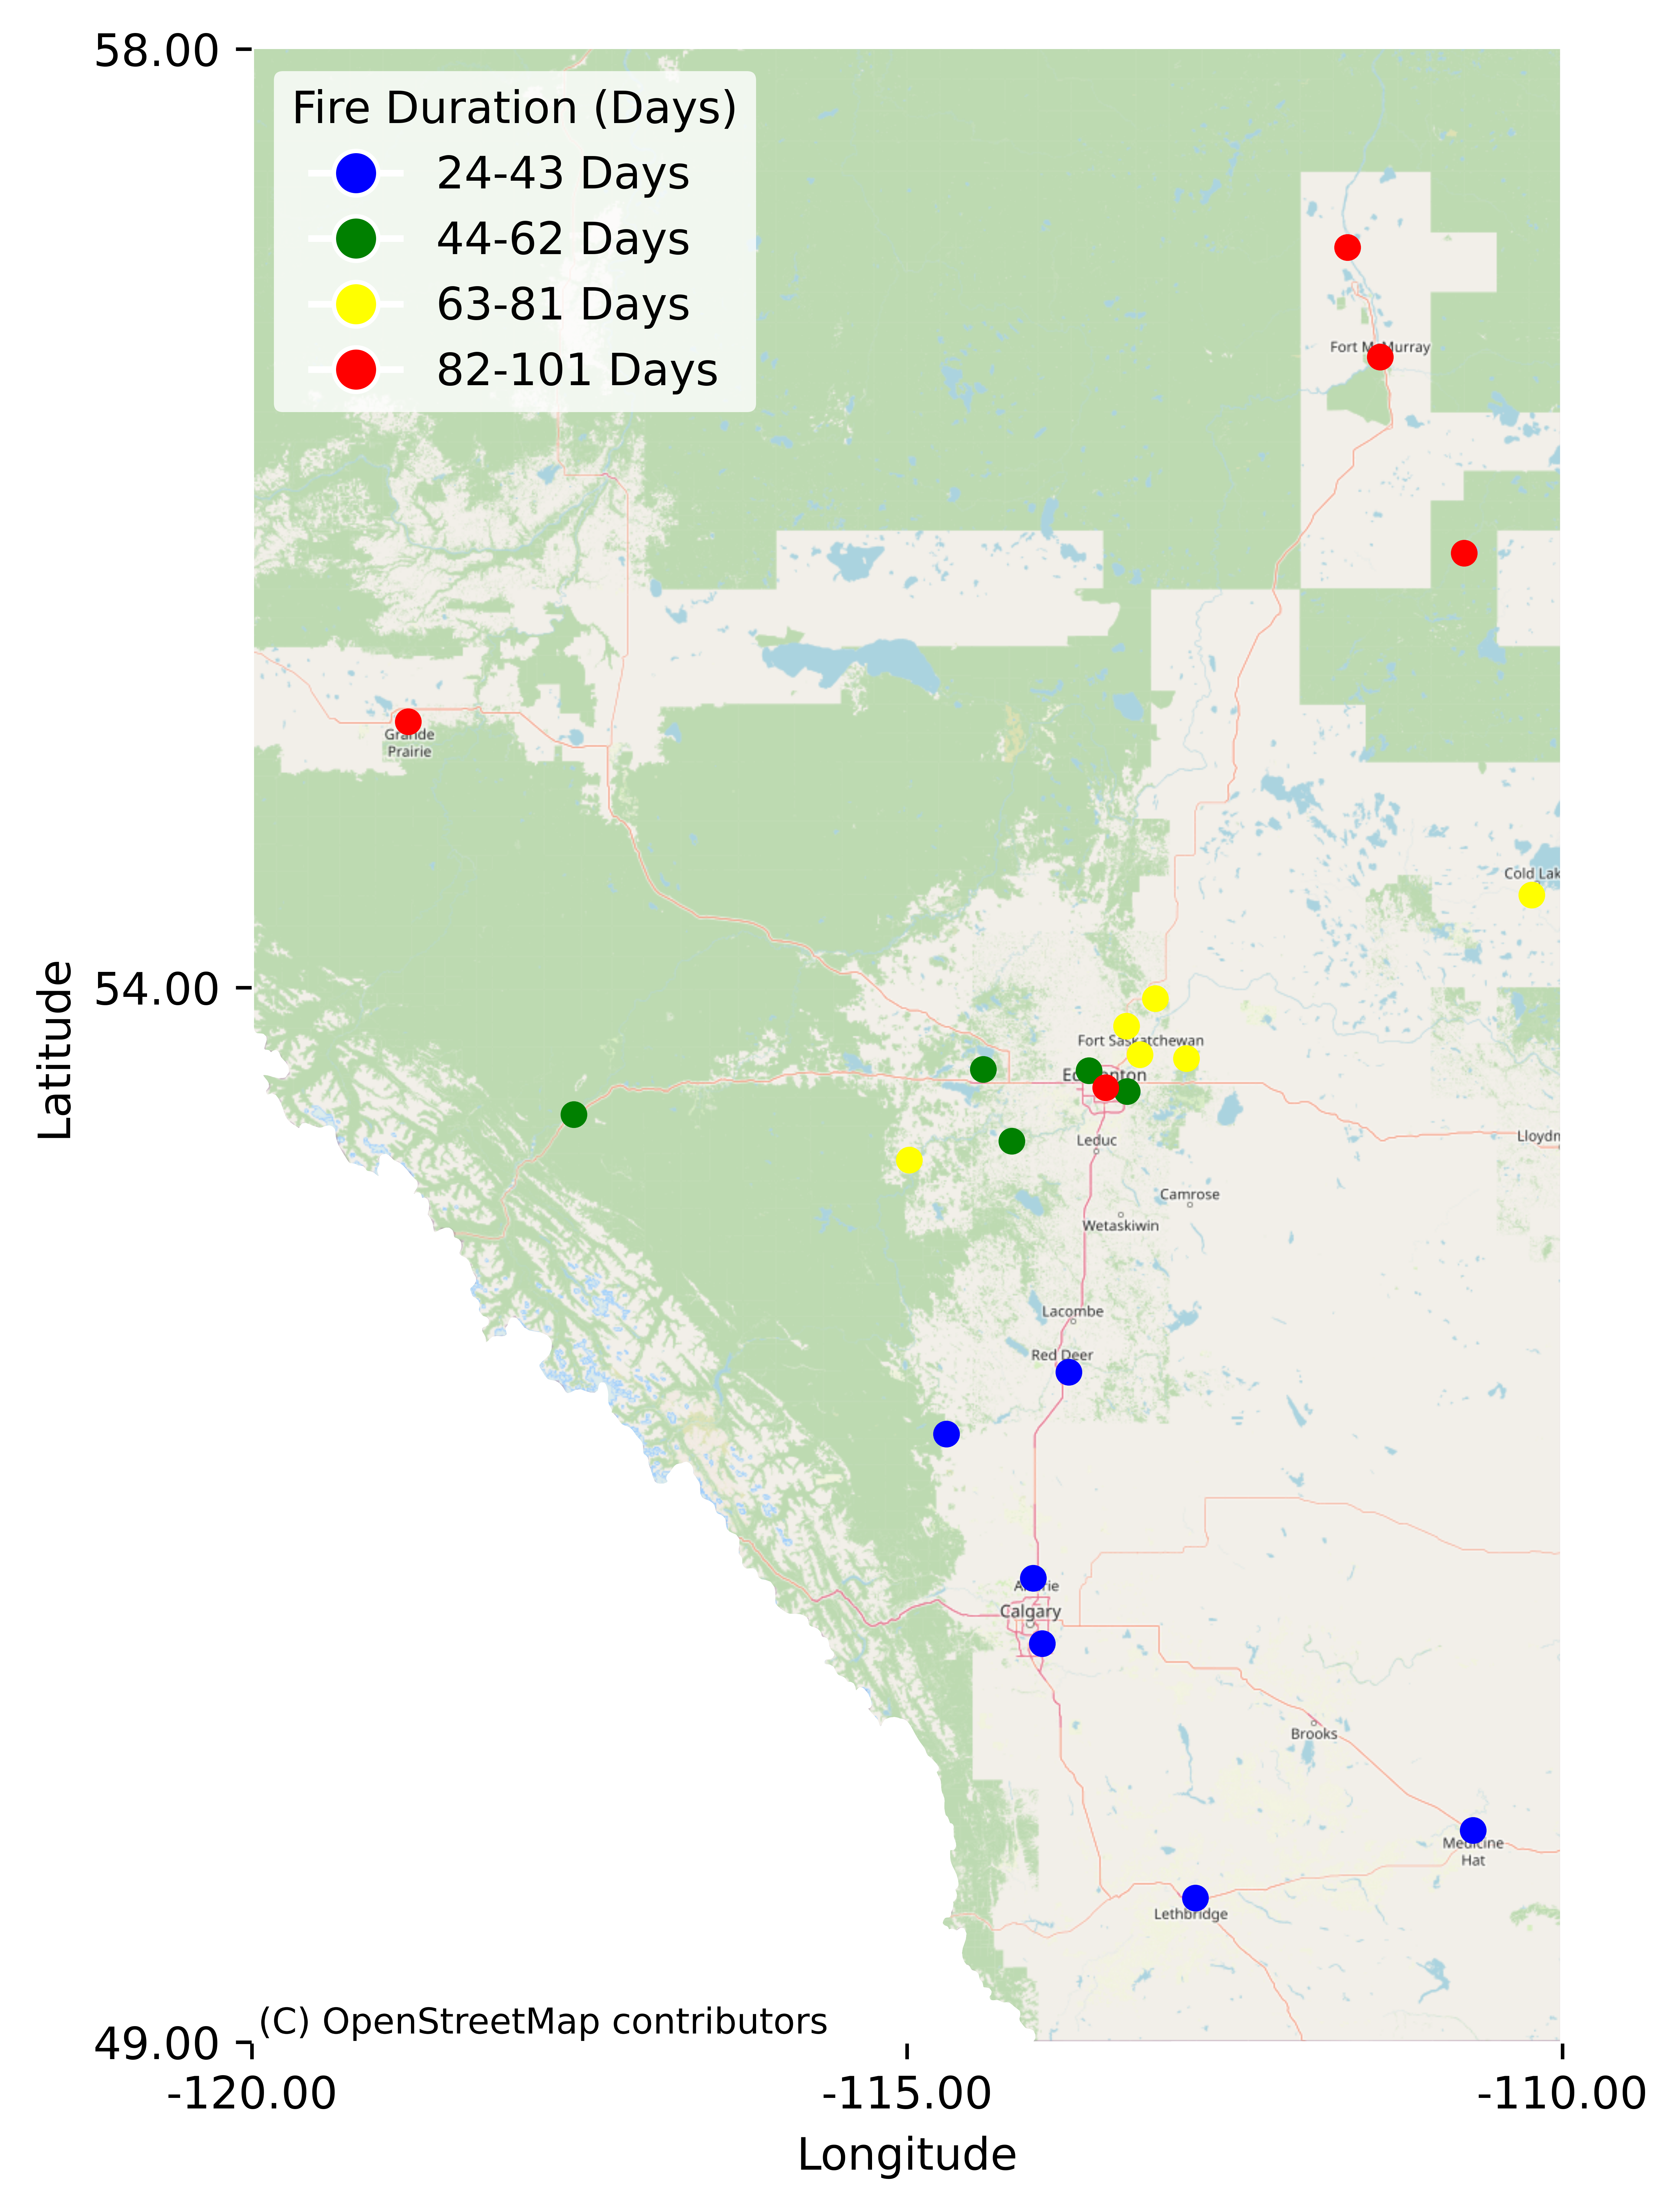

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, Polygon, box
from matplotlib.lines import Line2D
import pandas as pd
from shapely.ops import unary_union

# Data
data = {
    'Lat': [55.1766364, 53.4273011, 54.4138811, 55.9033, 56.7328, 57.189406, 49.7161843, 50.0488873, 50.955122, 51.268227, 51.95, 52.24095, 53.220056, 53.306507, 53.633, 53.549509, 53.53209, 53.6269722, 53.698756, 53.827241, 53.6824, 53.951834],
    'Lon': [-118.8077555, -117.544067, -110.2330575, -110.7499, -111.3902, -111.640504, -112.800586, -110.6811172, -113.969742, -114.037677, -114.7, -113.765439, -114.983408, -114.200347, -114.4199, -113.48593, -113.32098, -113.6119166, -113.222831, -113.327174, -112.8681, -113.105857],
    'duration': [89, 51, 75, 90, 101, 96, 26, 27, 43, 34, 24, 41, 64, 62, 58, 95, 57, 61, 72, 66, 69, 73]
}

# Create DataFrame
df_fire = pd.DataFrame(data)

# Categorize duration into bins and assign colors
bins = [24, 43, 62, 81, 101]
colors = ['blue', 'green', 'yellow', 'red']
df_fire['color'] = pd.cut(df_fire['duration'], bins=bins, labels=colors, include_lowest=True)

# Convert initial coordinates to GeoDataFrame
initial_coordinates = df_fire[['Lon', 'Lat']].values
initial_geometry = [Point(lon, lat) for lon, lat in initial_coordinates]
initial_gdf = gpd.GeoDataFrame(df_fire, geometry=initial_geometry, crs="EPSG:4326")


# Load the Alberta boundary shapefile and filter for Alberta
alberta_boundary = gpd.read_file('ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')
alberta_boundary = alberta_boundary[alberta_boundary['name'] == 'Alberta']  # Filter for Alberta only

# Plot the map with the basemap
fig, ax = plt.subplots(figsize=(6, 7), dpi=1000)  # Same figure size as reference
initial_gdf = initial_gdf.to_crs(epsg=3857)
alberta_boundary = alberta_boundary.to_crs(epsg=3857)


# Plot the Alberta boundary (same style as reference)
alberta_boundary.plot(ax=ax, color='none', edgecolor='white', linewidth=1, label='Alberta Boundary')

# Add the OpenStreetMap basemap (same zoom level as reference)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)

# Create a mask for the area outside Alberta 
minx, miny, maxx, maxy = alberta_boundary.total_bounds
entire_map = box(minx, miny, maxx, maxy)
mask_polygon = entire_map.difference(unary_union(alberta_boundary.geometry))
mask_gdf = gpd.GeoDataFrame(geometry=[mask_polygon], crs="EPSG:3857")
mask_gdf.plot(ax=ax, color='white', edgecolor='white')

# Plot the points with colors based on duration
for color in colors:
    subset = initial_gdf[initial_gdf['color'] == color]
    subset.plot(ax=ax, color=color, marker='o', markersize=25, label=f'Duration {color}')

# Function to convert latitude/longitude (EPSG:4326) to Web Mercator (EPSG:3857)
def to_web_mercator(lon, lat):
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326")
    point = point.to_crs("EPSG:3857")
    return point.x[0], point.y[0]  # Return x, y in Web Mercator

# Set the extent to cover Alberta but stop at 54°N (adjusted from reference)
_, max_y = to_web_mercator(0, 58.0)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, max_y)

# Set plot title and labels 
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Define specific ticks in latitude/longitude (EPSG:4326) (adjusted from reference)
xticks_4326 = [-120.00, -115.00, -110.00]
yticks_4326 = [49.00, 54, 58.00]

# Convert ticks to Web Mercator (EPSG:3857) 
xticks_3857 = [to_web_mercator(lon, 0)[0] for lon in xticks_4326]
yticks_3857 = [to_web_mercator(0, lat)[1] for lat in yticks_4326]

# Set the ticks and tick labels 
ax.set_xticks(xticks_3857)
ax.set_xticklabels([f"{lon:.2f}" for lon in xticks_4326])
ax.set_yticks(yticks_3857)
ax.set_yticklabels([f"{lat:.2f}" for lat in yticks_4326])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Create custom legend handles
duration_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='24-43 Days'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='44-62 Days'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, label='63-81 Days'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='82-101 Days')
]

# Add legend 
legend = plt.legend(handles=duration_handles, loc='upper left', title="Fire Duration (Days)")
frame = legend.get_frame()
frame.set_edgecolor('none')

# Save the figure to a PDF
plt.tight_layout()
plt.savefig("Alberta_Map_Fire.pdf", format="pdf", bbox_inches="tight", dpi=100)
plt.show()